In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos

Récupération des codes_bss par jointure de tables dans la base de données

In [17]:
region = "ARA"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        INNER JOIN code_region
            ON code_dpt = departement
        WHERE code_region IS '{region}'
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [18]:
code_bss

['06216X0228_P30-10',
 '06932X0178_P10',
 '06505X0093_PZ10',
 '05986X0103_P16-20',
 '07004X0046_D6-20',
 '06216X0226_P30-01',
 '07662X0277_45B-01',
 '07968X0186_RE11',
 '06932X0179_P11',
 '05986X0106_P16-21',
 '08915X0028_PMA-B1',
 '06935X0057_C1',
 '08422X0190_F1',
 '07022X0053_F1',
 '06552X0014_F1',
 '06935X0014_F1',
 '08125X0044_F1',
 '06781X0054_F1',
 '07948X0047_F1',
 '06754X0077_F1',
 '06783X0008_F1',
 '07034X0008_F1',
 '07477X0048_F1',
 '08664X0069_F1',
 '06932X0170_P1',
 '07421X0080_P1',
 '05736X0002_P1',
 '08153X0052_P1',
 '07703X0064_P1',
 '07916X0008_P1',
 '07657X0018_P1',
 '08187X0238_P1',
 '07955X0099_P1',
 '06995C0208_S1',
 '08184X0084_PZ1',
 '05986X0105_P16-02',
 '07662X0279_P45B02',
 '05991X0043_PZ32',
 '06993X0226_MEXI_2',
 '06533X0070_F2',
 '07733X0070_F2',
 '08422X0191_F2',
 '08907X1014_F2',
 '08424X0006_F2',
 '06541X0007_PI2',
 '08426X0133_P2',
 '06518X0026_P2',
 '07174X0179_P2',
 '07955X0101_PZ2',
 '07662X0278_45B-03',
 '06988X0246_WL03',
 '08413X0091_F3',
 '07475X

## Construction d'un dataframe

In [19]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [20]:
data

06216X0228_P30-10  06932X0178_P10  06505X0093_PZ10  \
date_mesure                                                       
1968-04-16                 NaN             NaN              NaN   
1968-08-01                 NaN             NaN              NaN   
1968-08-02                 NaN             NaN              NaN   
1968-08-03                 NaN             NaN              NaN   
1968-08-04                 NaN             NaN              NaN   
...                        ...             ...              ...   
2022-05-15                 NaN             NaN            -7.32   
2022-05-16                 NaN             NaN              NaN   
2022-05-17                 NaN             NaN              NaN   
2022-05-18                 NaN             NaN              NaN   
2022-05-19                 NaN             NaN              NaN   

             05986X0103_P16-20  07004X0046_D6-20  06216X0226_P30-01  \
date_mesure                                                           
1968-04-16                 NaN               NaN                NaN   
1968-08-01                 NaN               NaN                NaN   
1968-08-02                 NaN               NaN                NaN   
1968-08-03                 NaN               NaN                NaN   
1968-08-04                 NaN               NaN                NaN   
...                        ...               ...                ...   
2022-05-15                 NaN             -1.92                NaN   
2022-05-16                 NaN             -1.94                NaN   
2022-05-17                 NaN             -1.96                NaN   
2022-05-18                 NaN             -1.98                NaN   
2022-05-19                 NaN             -2.00                NaN   

             07662X0277_45B-01  07968X0186_RE11  06932X0179_P11  \
date_mesure                                                       
1968-04-16                 NaN              NaN             NaN   
1968-08-01                 NaN              NaN             NaN   
1968-08-02                 NaN              NaN             NaN   
1968-08-03                 NaN              NaN             NaN   
1968-08-04                 NaN              NaN             NaN   
...                        ...              ...             ...   
2022-05-15                 NaN           -17.86             NaN   
2022-05-16                 NaN              NaN             NaN   
2022-05-17                 NaN              NaN             NaN   
2022-05-18                 NaN              NaN             NaN   
2022-05-19                 NaN              NaN             NaN   

             05986X0106_P16-21  ...  06744X0025_PZ  07172X0116_PZ  \
date_mesure                     ...                                 
1968-04-16                 NaN  ...            NaN            NaN   
1968-08-01                 NaN  ...            NaN            NaN   
1968-08-02                 NaN  ...            NaN            NaN   
1968-08-03                 NaN  ...            NaN            NaN   
1968-08-04                 NaN  ...            NaN            NaN   
...                        ...  ...            ...            ...   
2022-05-15                 NaN  ...            NaN            NaN   
2022-05-16                 NaN  ...            NaN            NaN   
2022-05-17                 NaN  ...            NaN            NaN   
2022-05-18                 NaN  ...            NaN            NaN   
2022-05-19                 NaN  ...            NaN            NaN   

             08915X0026_PZ  06261X0007_PZ  08437X0027_PZ  08423X0067_PZ  \
date_mesure                                                               
1968-04-16             NaN            NaN            NaN            NaN   
1968-08-01             NaN            NaN            NaN            NaN   
1968-08-02             NaN            NaN            NaN            NaN   
1968-08-03             NaN            NaN            NaN            NaN 

## Visualisation des valeurs manquantes

In [21]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

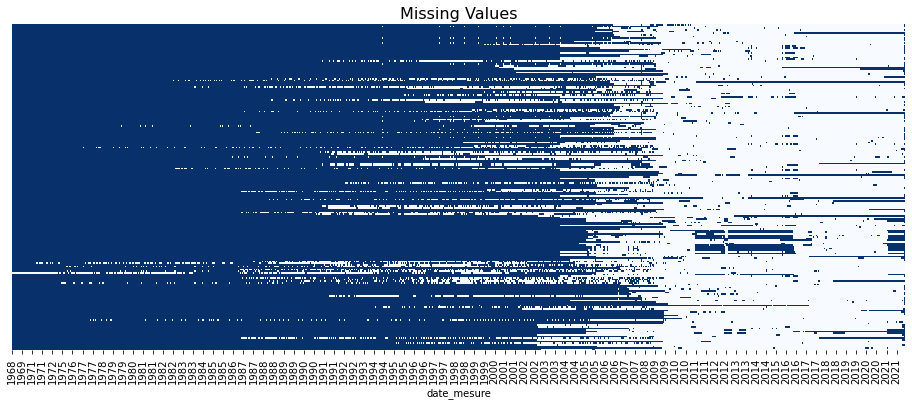

In [22]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [23]:
data_week = pd.DataFrame(data.resample('7D').mean())

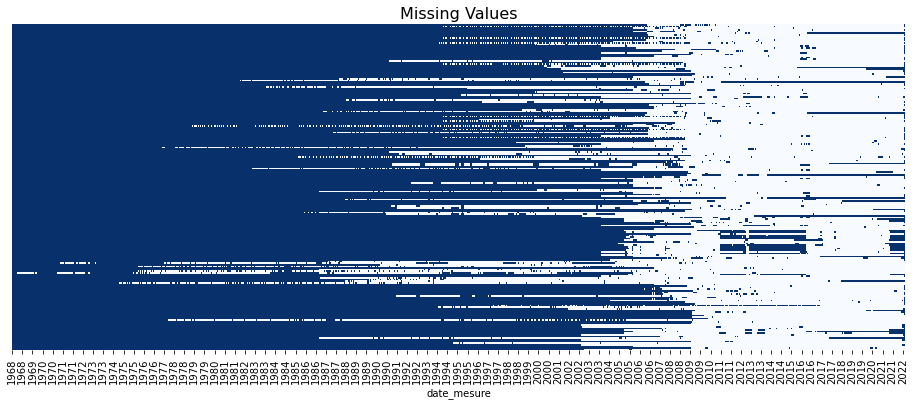

In [24]:
f_plot_nan(data_week)

In [25]:
data_week.shape

(2823, 200)

## Echelle de temps fixée après 2009 pour limiter les Nan

In [47]:
data_week_from_ = data_week.loc['01-01-2009':]

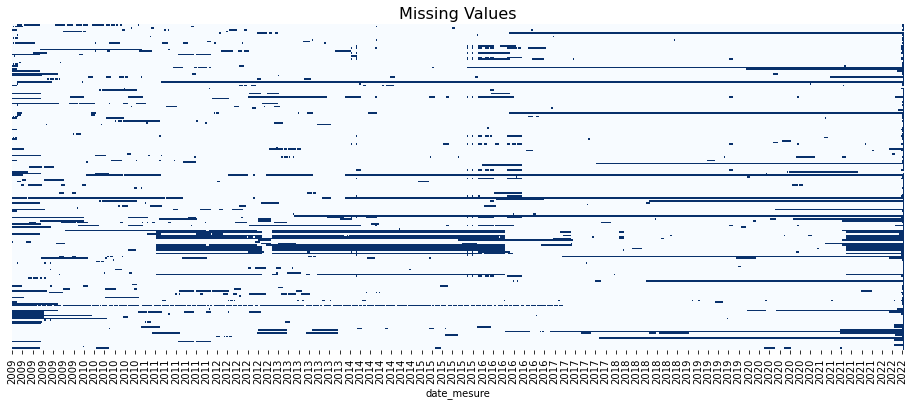

In [48]:
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [49]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 13533 valeurs nulles dans l'ensemble du dataframe.


In [50]:
data_wo_outliers = data_week_from_.copy()

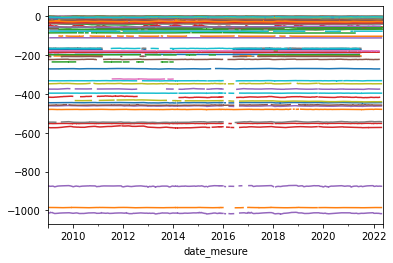

In [51]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

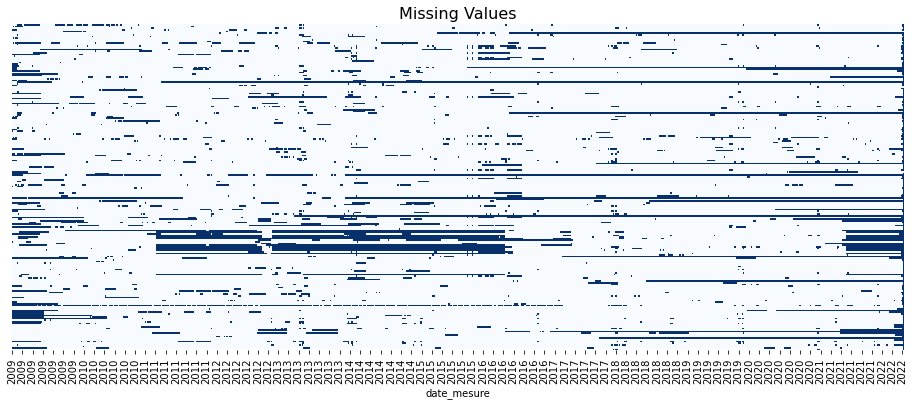

In [52]:
f_plot_nan(data_wo_outliers)

In [53]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 15798 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 5% de valeurs manquantes

In [54]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.05*data_wo_outliers.shape[0]].columns

In [55]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

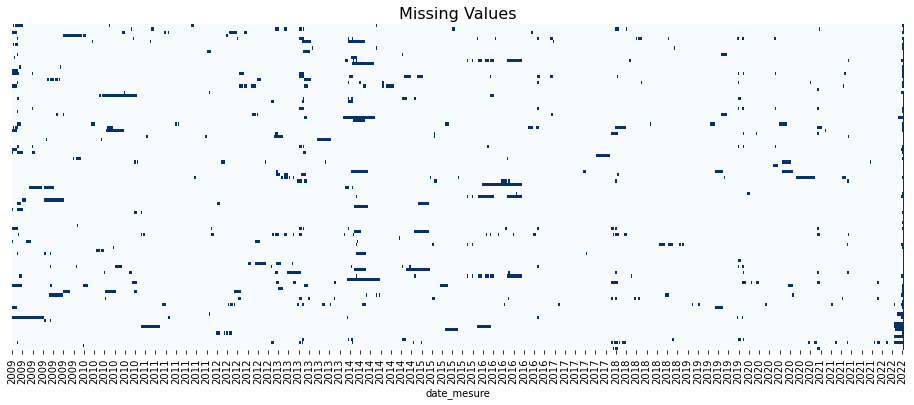

In [56]:
f_plot_nan(data_clean)

In [57]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 1503 valeurs nulles dans l'ensemble du dataframe.


In [58]:
data_clean.shape

(698, 103)

## Interpolation

In [59]:
data_interpol = data_clean.copy().interpolate('linear')

In [60]:
data_interpol.shape

(698, 103)

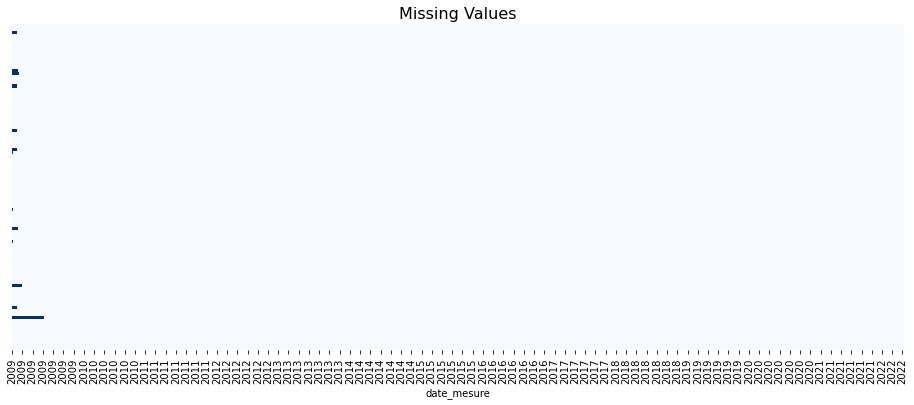

In [61]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [62]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [63]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-17 00:00:00', freq='7D')

In [64]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [65]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [66]:
data_interpol.shape

(673, 103)

In [67]:
data_interpol.shape[1]

103

## Affichage des chroniques après nettoyage

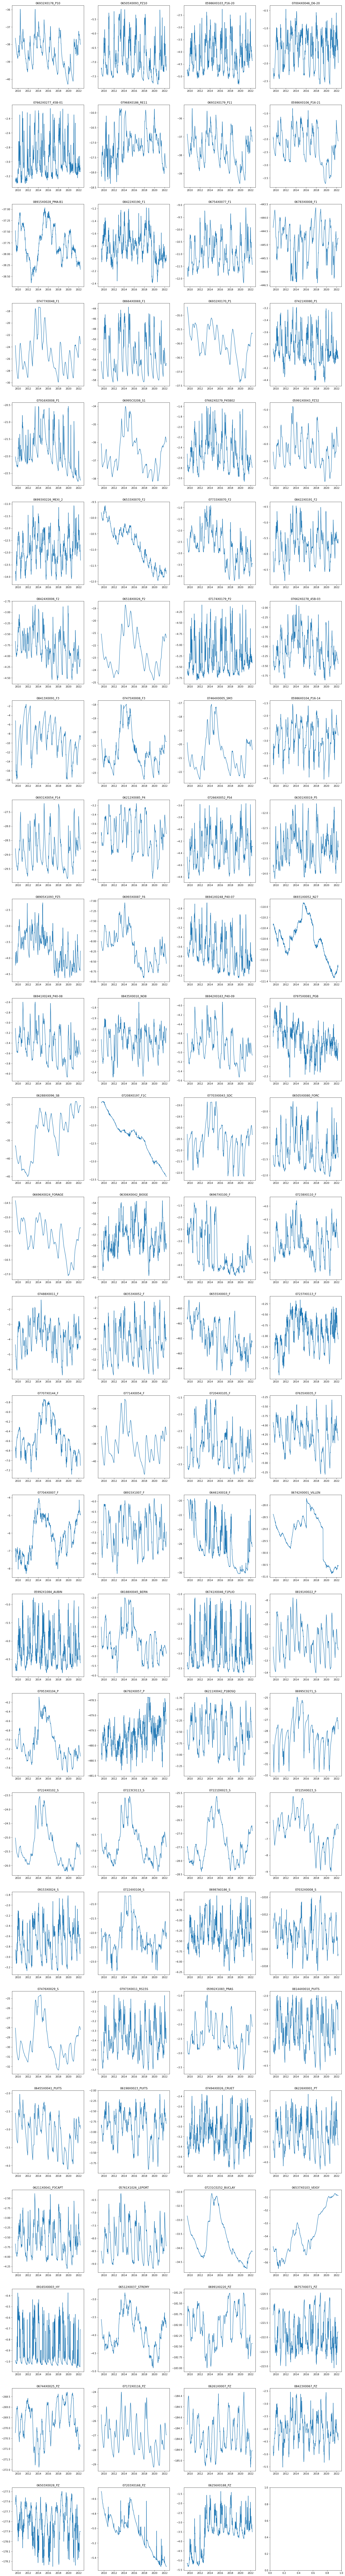

In [68]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

Comme il n'y a visuellement pas de valeurs abbérantes qui sautent aux yeux, la normalisation choisie est la standardisation

In [69]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [70]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [71]:
data_norm.head()

06932X0178_P10  06505X0093_PZ10  05986X0103_P16-20  \
date_mesure                                                       
2009-06-30         0.974890        -0.515703          -0.881227   
2009-07-07         0.874945        -0.594450          -0.932414   
2009-07-14         0.820737        -0.515703          -0.834492   
2009-07-21         0.751284        -0.571951          -0.899031   
2009-07-28         0.646257        -0.702446          -1.088197   

             07004X0046_D6-20  07662X0277_45B-01  07968X0186_RE11  \
date_mesure                                                         
2009-06-30          -1.069515          -1.151472        -1.854651   
2009-07-07          -1.207593          -1.145651        -1.681001   
2009-07-14          -1.272226          -1.151472        -2.044839   
2009-07-21          -1.313355          -1.244612        -1.705808   
2009-07-28          -1.457309          -1.134008        -1.350240   

             06932X0179_P11  05986X0106_P16-21  08915X0028_PMA-B1  \
date_mesure                                                         
2009-06-30         1.028177           0.567359           0.769363   
2009-07-07         0.921505           0.432011           0.614899   
2009-07-14         0.869016           0.438893           0.390559   
2009-07-21         0.789435           0.464127           0.283905   
2009-07-28         0.681070           0.198020           0.151508   

             08422X0190_F1  ...  06512X0037_STREMY  06991X0220_PZ  \
date_mesure                 ...                                     
2009-06-30       -0.177832  ...           0.723080       0.071275   
2009-07-07       -0.132961  ...           0.644633       0.329548   
2009-07-14       -0.344493  ...           0.566187       0.445091   
2009-07-21       -0.562435  ...           0.541646       0.536846   
2009-07-28       -1.094469  ...           0.435633       0.750940   

             06757X0071_PZ  06744X0025_PZ  07172X0116_PZ  06261X0007_PZ  \
date_mesure                                                               
2009-06-30        0.979375      -0.643039       1.406255       0.647352   
2009-07-07        1.026973      -0.514117       1.207768       0.881595   
2009-07-14        1.098370      -0.431607       1.039716       0.853486   
2009-07-21        1.131688      -0.383476       0.869018       1.200166   
2009-07-28        1.257822      -0.242521       0.719491       1.471888   

             08423X0067_PZ  06503X0028_PZ  07203X0168_PZ  06256X0188_PZ  
date_mesure                                                              
2009-06-30       -1.180789       1.076367       2.205785      -1.758128  
2009-07-07       -1.418730       1.282887       2.155658      -1.796644  
2009-07-14       -1.781126       1.257072       2.144519      -1.762750  
2009-07-21       -1.843986       1.437778       2.116671      -1.813591  
2009-07-28       -1.887018       1.532433       2.094393      -1.870595  

[5 rows x 103 columns]

## Sauvegarde du dataframe en csv

In [72]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")